In [15]:
%%HTML
<link rel="stylesheet" type="text/css" href="../css/custom.css">

# Convolutions
![footer_logo](../images/logo.png)

## Goal

Understand the effect of applying a convolution on an image.

## Program

We will first discuss what a convolution is (and a cross-correlation)

- [Convolutions]()

We shall then discuss some simple operations and padding

- [Identity operation]()
- [Translation]()
- [Padding]()

Afterwards we shall demonstrate some common operations on an image file and discuss the limitations.

- [Example operations]()
- [Limitations]()

In [1]:
import numpy as np 
from scipy.signal import convolve, correlate2d

---
## Convolutions

A convolution operation on an input image is the process of producing an output by
combing each pixel of an image with its local neighbours, weighted by a kernel. 

Imagine an input I with convolution kernel K. The value for a position i in the output can be specified
as $V_i = ∑ I_{i+k−j}K_j$, where j is the index over the kernel and k the center position of the j
kernel.

Intuitively, it can be seen as calculating the dot product between input I and the $180^o$ degree rotation of kernel K. 

However, in practice, most deep learning algorithms/frameworks do not actually bother with the $180^o$ degree rotation. This means we are actually performing a **cross-correlation**.

![](../images/convolutions/convolution_schematic.gif)

## Identity operation
A simple example of a convolution is that of the identity operation. The figure shows how a 3 × 3 convolution kernel can be used as an identity operator to produce an output value for the center position. As all weights besides that of the center position are zero, these do not contribute towards the output value, whereas the center value does.

![](../images/convolutions/identity-conv.png)

We can perform convolutions with Python by representing the input and kernel to be convolved as `numpy` arrays.

In [2]:
x = np.array([[1, 2, 3], 
              [4, 5, 6], 
              [7, 8, 9]])
kernel = [[0, 0, 0], 
          [0, 1, 0], 
          [0, 0, 0]]

In [3]:
output = convolve(x, kernel, mode='same')
print(output)

[[1 2 3]
 [4 5 6]
 [7 8 9]]


In [4]:
output = correlate2d(x, kernel, mode='same')
print(output)

[[1 2 3]
 [4 5 6]
 [7 8 9]]


## Translation

This figure shows how a convolution can be used to essentially _translate_ the input by giving a weight to the value at a different position.

![](../images/convolutions/translation-conv.png)

In [5]:
x = np.array([[1, 2, 3], 
              [4, 5, 6], 
              [7, 8, 9]])
kernel = [[1, 0, 0], 
          [0, 0, 0], 
          [0, 0, 0]]

In [6]:
output = correlate2d(x, kernel, mode='same')
print(output)

[[0 0 0]
 [0 1 2]
 [0 4 5]]


## Padding 

The translation example immediately illustrates the problem with convolutions and the edges of an image: how can, for instance, the value for the last position be calculated, which does not have a 3 × 3 neighbourhood, and therefore also no value with which the weight of one can be multiplied? 

#### Valid padding
One solution is to discard the edge cases in their entirety, producing no value at all at those positions at which the kernel cannot be validly applied to the position – called _valid padding_. An consequence of this approach, however, is that the output will have less values than the input, which may be undesirable. 

#### Same padding 
An alternative therefore is same padding, which ensures the output of the convolution is of a similar size to the input by filling in values for non-existing positions, such as zero, the average of the neighbourhood, or the nearest neighbour. 

![](../images/convolutions/padding-conv.png)


In [7]:
x = np.array([[1, 2, 3], 
              [4, 5, 6], 
              [7, 8, 9]])
kernel = [[1, 0, 0], 
          [0, 0, 0], 
          [0, 0, 0]]

In [8]:
output = correlate2d(x, kernel, mode='valid')
print(output)

[[1]]


In [9]:
output = correlate2d(x, kernel, mode='same')
print(output)

[[0 0 0]
 [0 1 2]
 [0 4 5]]


---
## Example operations

The convolutions we have seen so far were all on relatively small and simple `numpy` arrays. However, as the kernel _slides_ over the input, a $3\times 3$ kernel can be applied on any input size, including images. This can lead to some interesting results. 

Let's load in an image and see what transformations we can apply to it.

(333, 500)


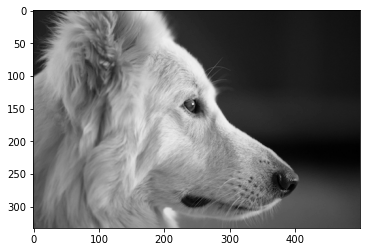

In [10]:
from scipy.ndimage.filters import convolve, correlate
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
plt.gray()

img = mpimg.imread('../images/transfer_learning/dog.png')
print(img.shape)
plt.imshow(img);

## Identity operation

First of all, the identity operation as seen before can be applied to the image. What output do you expect?

In [11]:
kernel = np.array([[0, 0, 0], 
                   [0, 1, 0], 
                   [0, 0, 0]])

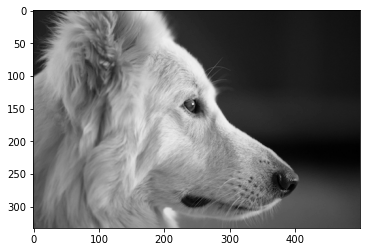

In [12]:
filtered_img = correlate(img, kernel)
plt.imshow(filtered_img);

## Blur

Besides the identity operation and translation, there are some other operations we can perform with a convolution - such as a blurring operation. 

So what is blurring, exactly? Well, the purpose of blurring an image is to reduce the image's level of detail, but still maintain the rough outline or main content. This means each pixel needs to be edited in some way that it is noticeably different from before, but close enough to the original to give a rough idea of the original content. If we were to alter each pixel value based on the neighbouring pixels, the pixels would still contain information about the original value, but all neighbouring pixels would become more similar... like you would expect in a blurred image. 

So how would you construct a kernel for a blurring operation? Well, we have to define the neighbourhood of pixels to consider. Each of the pixels in the neighbourhood should contribute equally to the output value. Then, when we convolve a pixel with a the pixels surrounding it, every pixel contributes equally to the output value and the new value for the pixel will become a smooth mix of the pixel information surrounding it. 

In [13]:
BLUR_NEIGHBOURHOOD = 30

kernel = np.ones((BLUR_NEIGHBOURHOOD, BLUR_NEIGHBOURHOOD)) 
kernel = kernel / np.sum(kernel)
kernel.shape

(30, 30)

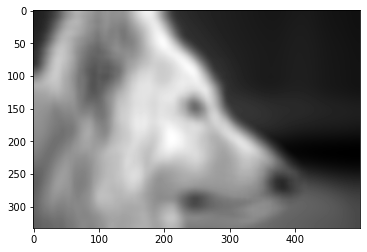

In [14]:
filtered_img = correlate(img, kernel)
plt.imshow(filtered_img);

## Unsharp masking

Besides blur, we can also sharpen an image with unsharp masking, although this is slightly more complicated. Imagine this: what is the opposite of a sharpened image? A blurry one. With a convolution, we can blur an image. If we take the original image, and subtract the blurriness, we should be left with the parts that are high-contrast, i.e. sharpened image! 

In [15]:
BLUR_NEIGHBOURHOOD = 10

# Create blurred image
kernel = np.ones((BLUR_NEIGHBOURHOOD, BLUR_NEIGHBOURHOOD)) 
kernel = kernel / np.sum(kernel)
kernel.shape

(10, 10)

In [16]:
blurred_img = correlate(img, kernel)

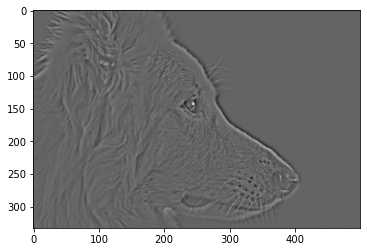

In [17]:
# Subtract blurred image from original
sharpened_img = img - blurred_img
plt.imshow(sharpened_img)

## Motion blur

Motion blur is a special type of blur that typically occurs when the camera is moved while an image is captured. We can replicate this with a convolution as well: for each pixel value we don't take all the pixel values in the neighbourhood into account, such as with regular blurring, but only in a specific direction. A kernel might look like: [1, 1, 1, 1, 0, 0, 0, 0]

In [18]:
factor = 30
kernel = np.zeros((1, factor * 2))

#kernel[:,0:factor] = 1
kernel[0:factor] =1

kernel.shape

(1, 60)

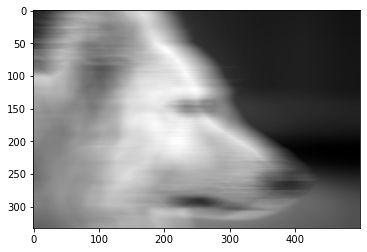

In [19]:
filtered_img = correlate(img, kernel)
plt.imshow(filtered_img);

## Edge detection

Convolutions may even be used for more advanced - and helpful in the context of image processing! - operations, such as edge detection. Firstly, we create a kernel that will help us detect the edges in the image. 

With this filter, the output will be 0 in a region where all pixel values are the same. This means regions in the image where pixel values change (edges) will be highlighted.

In [20]:
kernel = np.array([[-1, -1, -1], 
                   [-1, 8, -1], 
                   [-1, -1, -1]])

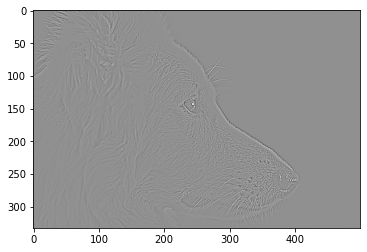

In [21]:
filtered_img = correlate(img, kernel)
plt.imshow(filtered_img);

Secondly, we want to highlight the found edges.

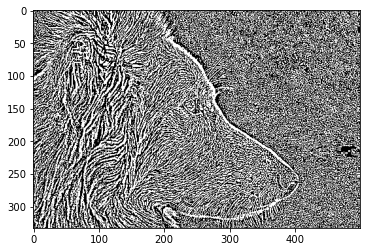

In [22]:
a = filtered_img
a[a > 0] = 1
a[a < 0] = 0 
plt.imshow(a);

---
## Summary: Limitations of convolutions

Convolutions are hugely useful for many image processing tasks. However, there is a limitation: a constraint for convolutions is that the same operation is applied to all pixels. If it didn't, the filter would be limited to particular perspectives/scales/objects etc.

This means certain operations cannot be performed. 

![](../images/convolutions/dataaugmentation.png)

Can you think of why these operations cannot be performed with a convolution?